    
# Heavy Heart
<font color='red'>Heavy Heart</font> uses data collected on random users publicly posted tweets to  diagnose users with clinical depression. By using machine learning, Heavy Heart determines if a user should be recommended help based on the frequency and percentage of negative tweets compared to other tweets in the users feed.
* * *

### Import statements and data structure declarations
Here <font color='red'>Heavy Heart</font> imports a number of libraries important to the success of the process.  The most important being the tweepy library which allows <font color='red'>Heavy Heart</font> to directly connect with the Twitter API. <font color='red'>Heavy Heart</font> also declares a few data structures for later use.

In [1]:
import re
import math
import tweepy
import io
import time
import matplotlib
import matplotlib.pyplot as plt
import json
import numpy as np
from tweepy import OAuthHandler
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
import pandas
test_data=[]
train_control=[]
train_depressed=[]
data = []

### Authentication, tokens and keys
<font color='red'>Heavy Heart</font> declares the keys and tokens needed by twitter's developer api and tweepy. Then <font color='red'>Heavy Heart</font> authenticates the connection with twitter through tweepy.

In [2]:
consumer_key = 'n4zRm3xuVoYoBHDLbSSqCxlII'
consumer_secret = 'i2bxYM53rVNv0NFnO4iALdUYUDXHSEp9JARjpSu6290B5W6BLj'
access_token = '3265727682-sWioD71Vv1zJie1KCERyHZWgzCdDsGAy3lzdLJA'
access_token_secret = 'Ir9vMlPyiJwafcqXOiRJgtdWpev2VU3rI0Z2MWXlJ79SV'

        # attempt authentication
try:
            # create OAuthHandler object
    auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
    auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
    api = tweepy.API(auth,wait_on_rate_limit=True)
except:
    print("Error: Authentication Failed")

### Cleaning raw extracted tweets
clean_tweet(tweet) removes unessary characters from the tweet to cut down on processing time and potential future errors.

In [3]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split())


### Determining tweet sentiment
Using the reduced tweet obtained with clean_tweet, <font color='red'>Heavy Heart</font> classifies the sentiment of the tweet passed in using textblob's sentiment method.

In [4]:
def get_tweet_sentiment(tweet):
    """
    Utility function to classify sentiment of passed tweet
	using textblob's sentiment method
	"""
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

### Parsing tweets
<font color='red'>Heavy Heart</font> uses get_tweets to collect all tweets of a certain query.  <font color='red'>Heavy Heart</font> specifically uses this function when searching for tweets which show negative sentiment by using queries such as '#depressed' or '#depression'

In [5]:
users = []
def get_tweets(query, count=10):
        # empty list to store parsed tweets
        tweets = []

        try:
            # call twitter api to fetch tweets, set language to english
            fetched_tweets = api.search(q=query, count=count, lang="en")
            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                users.append(tweet.user.screen_name)
                parsed_tweet = clean_tweet(tweet.text)
                # saving text of tweet
                # saving sentiment of tweet

                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append((parsed_tweet,tweet.user.screen_name))
                else:
                    tweets.append((parsed_tweet,tweet.user.screen_name))

                # return parsed tweets
            return tweets

        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
            

### Keywords
<font color='red'>Heavy Heart</font> declares the lists of key words the algorithm searches for when parsing for tweets.  Using these keywords, <font color='red'>Heavy Heart</font> is trained to better identify negative sentiment tweets.

In [6]:
# train_depressed = get_tweets(query="#depressed",count = 50)
# train_depressed = list(filter(lambda x:get_tweet_sentiment(tweet=x)=="negative",train_depressed))
# train_control = get_tweets(query="the",count = 50)
# test_data = get_tweets(query="#anxiety",count = 50)
keywords2 = ["e%20","s%20","%20t","%20a","%20f"]
keywords = ["I need someone to talk to", "depressed", "wanna talk to someone", "want to talk to someone", "#depressed",
                "#depression", "lonely", "alone", "sad", "i'm worthless", "falling apart", "disappointed in myself", "i'm the worst", "i'm useless", "i am useless", "i'm a failure", "I am a failure", "too much pain", "unfair", "i'm not happy", "i am not happy", "unhappy", "regret", "have no one", "I don't know what to do", "i'm lost", "i am lost", "i am so lost", "hate me", "kill myself", "end myself", "end my life", "want to die", "I want to commit suicide", "i'm no good", "feel like shit", "i feel invisible", "suicide", "mad at me", "I feel dead", "mental health", "meaningless", "bomb this test", "fail this test", "fail this", "unloved", "ugly", "fat", "disgusting", "deal with", "deal with pain", "deal with the pain", "never healed", "not healed", "upset", "shut myself down", "no motivation", "nobody cares", "broken", "never wake up", "never wake", "my fault", "give an end to my fucking life", "I never existed", "suicidal", "sick of", "tears", "hurt me", "bullying", "you're going to fail", "do it until you die", "miserable", "pointless", "waste of time", "die alone", "what's the point", "everything is awful", "abandon", "abandonment", "worse and worse", "never gets better", "misery", "regret", "I'll ruin it", "never been born", "horrible life", "dead inside", "I am going to fail", "I am not happy", "I am the worst", "I am worthless", "ruin it", "emotionless", "sorry", "I am tired", "I'm tired", "mean nothing"]
        

### Saving the data
<font color='red'>Heavy Heart</font> saves the data to a json file in order to use the data in future searches to avoid reparsing large amounts of twitter tweets.

In [7]:
def save_data_to_json():
    data = []
    import json
    print("%s, %s",len(train_depressed),len(train_control))
    for x in train_depressed:
        data.append({"text":x[0],"label":"depressed","user":x[1]})
    for x in train_control:
        data.append({"text":x[0],"label":"not depressed","user":x[1]})
    with open('train.json','w') as fp:
        json.dump(data,fp)

### Building a training set
<font color='red'>Heavy Heart</font> continuously queries twitter over the keywords for tweets.  crawl_twitter() labels each tweet based on their sentiment (calculated with get_tweet_sentiment()).  <font color='red'>Heavy Heart</font> creates a labeled 'depressed' list and a labeled 'not depressed' list as a control group.

In [8]:
 def crawl_twitter():
    import json
    i=0
    minutes=16
    while(len(train_depressed)<1000):
        tweets = (get_tweets(query=keywords[i%len(keywords)],count = 100))
        for x in tweets:
            if(get_tweet_sentiment(x[0])=='negative'):
                train_depressed.append(x)
        tweets = get_tweets(query=keywords2[i%len(keywords2)],count = 100)
        for x in tweets:
            train_control.append(x)
        i+=1
        save_data_to_json()

#crawl_twitter()

### Loading the training data
Here <font color='red'>Heavy Heart</font> loads the training data stored in a json file.

In [9]:

with open('train.json','r') as fp:
    cl = NaiveBayesClassifier(fp,format='json')


### Classifying tweets
<font color='red'>Heavy Heart</font> uses is_depressed to calculate a specific tweets sentiment value to determine whether a tweet is negative, neutral or positive.  This process is performed on the depressed training group as well as the control group in order to further test results.

In [10]:
def is_depressed(review):
  if(is_depressed.counter==0):#define probabilities
      is_depressed.lenP = 0
      is_depressed.lenN = 0
      is_depressed.countMapD = {}#depressed revieww 
      is_depressed.countMapC = {}#Control review
      print("defining probabilities, this will take a while")
      for depressedReview in train_depressed:
          for word in depressedReview[0]:
              is_depressed.lenP+=1
              if(is_depressed.countMapD.__contains__(word)):
                  tempDic = {word: is_depressed.countMapD.get(word) + 1}
                  is_depressed.countMapD.update(tempDic)
              else:
                  is_depressed.countMapD.update({word: 1})
      for controlReview in train_control:
          for word in controlReview[0]:
              is_depressed.lenN+=1
              if (is_depressed.countMapC.__contains__(word)):
                  tempDic = {word: is_depressed.countMapC.get(word) + 1}
                  is_depressed.countMapC.update(tempDic)
              else:
                  is_depressed.countMapC.update({word: 1})
  is_depressed.counter+=1
  logProductP = 0
  logProductN = 0
  probPos = float(is_depressed.lenP)/float(is_depressed.lenP+is_depressed.lenN)
  probNeg = float(is_depressed.lenN)/float(is_depressed.lenP+is_depressed.lenN)
  for word in review:
      logProductN += math.log(float(is_depressed.countMapC.get(word,1)))
      logProductP += math.log(float(is_depressed.countMapD.get(word,1)))
  return logProductP-math.log(float(is_depressed.lenP))>logProductN-math.log(float(is_depressed.lenN))

is_depressed.counter = 0
is_depressed.lenP = 0
is_depressed.lenN = 0
is_depressed.countMapD = {}
is_depressed.countMapC = {}

In [11]:
for x in train_depressed:
    print(round(cl.prob_classify(x).prob("depressed"),3))
    print(cl.prob_classify(x).max())

### Resultant data
<font color='red'>Heavy Heart</font> uses all the previous code segments to apply machine learning ideas in order to learn more about twitter user's mental state based on their tweet history versus the twitter history <font color='red'>Heavy Heart</font> learned.  getTimeline allows <font color='red'>Heavy Heart</font> to retrieve the timeline of a specified user.  aveDepression and percentTweetsDepressed use the timeline returned from getTimeline in order to calculate, respectively, the average depression rating per tweet of a user and the percent of depressed tweets the user has had during their past ~3000 tweets.

In [12]:
def getTimeline(username):
  timeline = []
  #api = GetTimeline().api
  for status in tweepy.Cursor(api.user_timeline, screen_name = username, count = 20, wait_on_rate_limit = True, wait_on_rate_limit_notify = True).items():
    timeline.append(status.text)
  return timeline

def aveDepression(user):
    timeline = getTimeline(user)
    probDepressed = []
    for x in timeline:
        probDepressed.append(cl.prob_classify(x).prob("not depressed"))
    return sum(probDepressed)/float(len(probDepressed))

def percentTweetsDepressed(user):
    timeline = getTimeline(user)
    depressed = 0
    control = 0
    for x in timeline:
        if(cl.prob_classify(x).max()=="depressed"):
            depressed+=1
        else:
            control+=1
            
    print('Negative Tweets', depressed)
    print('Total tweets', float((depressed+control)))
    return depressed/float((depressed+control))

### Visualization
We can see this data visualized below with an example of YouTuber and streamer Boogie2988 and his recent twitter tweet content history.  This system can be applied to any twitter user in order to retrieve information about whether or not they should be recommended useful clincal depression resources over direct message.

Negative Tweets 545
Total tweets 3199.0


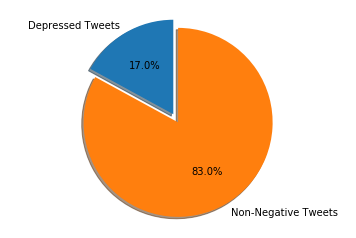

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Depressed Tweets', 'Non-Negative Tweets'
percent = percentTweetsDepressed('Boogie2988')
sizes = [percent, 1-percent]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()